# Generate figures for publication
_[work in progress]_

# Injection analysis

Loaded 3 trials.
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-20-F1Num8REP/Zyla_5min_RHLstim_2son4soff_1pt25pctISO_6/mask_processed_Zyla_5min_RHLstim_2son4soff_1pt25pctISO_6.npy
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-20-F1Num8REP/Zyla_15min_RHL_salineInj_1pt5pctISO_1/mask_processed_Zyla_15min_RHL_salineInj_1pt5pctISO_1.npy
Loading mask file from: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-03-20-F1Num8REP/Zyla_30min_RHL_histStockInj_1pt5pctISO_1/mask_processed_Zyla_30min_RHL_histStockInj_1pt5pctISO_1.npy
Loaded 3 masks.
Loaded 3 traces.
Loaded 3 sync infos.


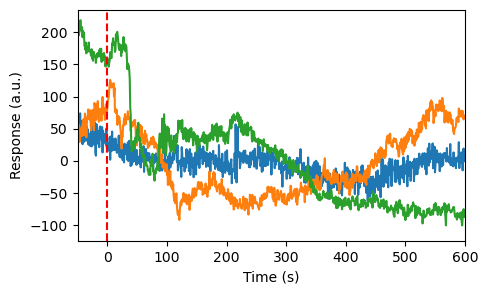

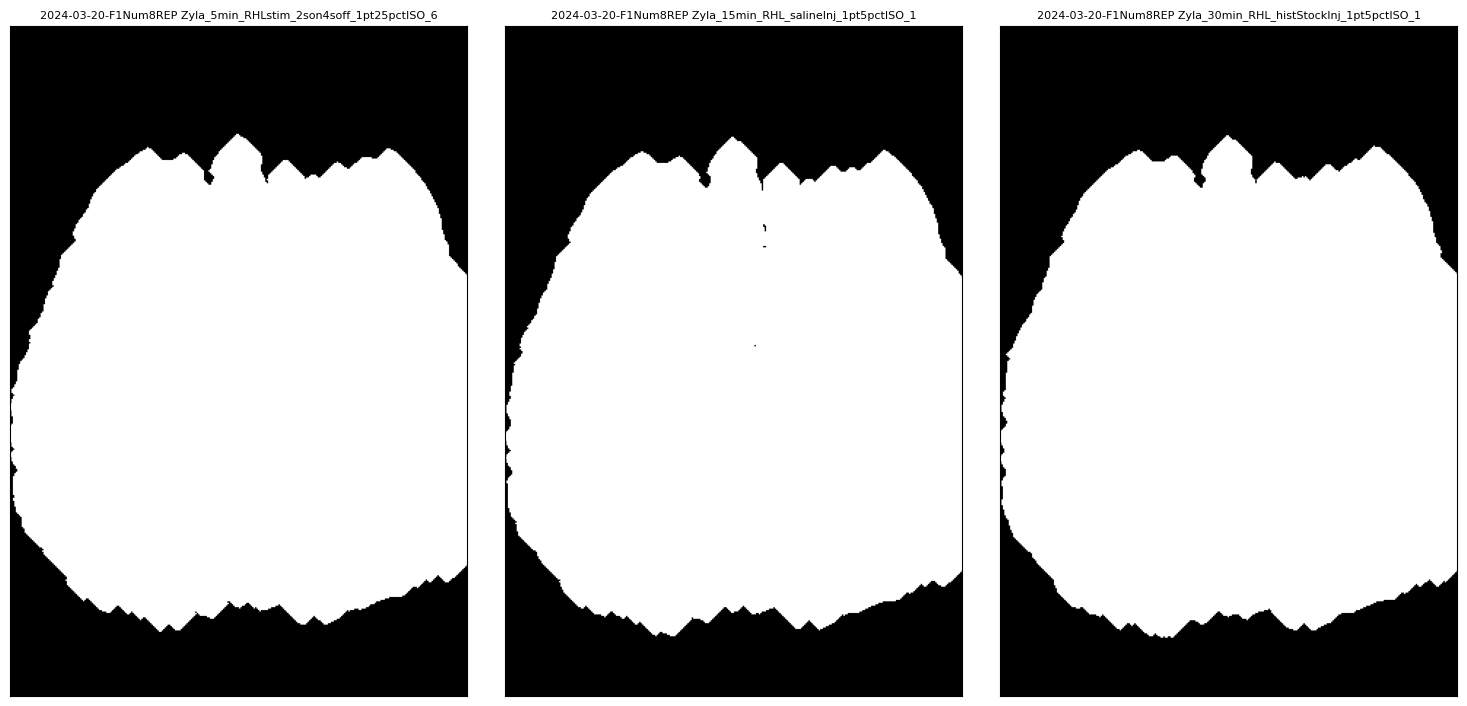

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from neuroprocessing.imagingtrials import ImagingTrialLoader

params = {
        "downsample_factor": 8,
        "aligner_target_num_features": 700,
        "secs_before_stim": 60, # only process frames starting at X seconds before stimulus
        "preprocess_prefix": "aligned_downsampled_",
        "process_prefix": 'processed_',
        "s3fs_toplvl_path": "/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos",
        "local_toplvl_path": "/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/",
        "load_from_s3": False,
        "save_to_s3": False,
        'crop_px' : 20,
        'bottom_percentile' : 5
        }

trials = ImagingTrialLoader(params)
exp_dates, trial_names = trials.filter_exp_and_trial_dirs(exp_dir="2024-03-20-F1Num8REP",
                                                          limb='RHL'
                                                        )
# exp_dates, trial_names = trials.filter_exp_and_trial_dirs()

masks = trials.load_mask_files()
traces = trials.load_traces()
sync_infos = trials.get_sync_infos()
# Plot the traces

fig, ax = plt.subplots(figsize=(5,3))
for trace, exp_date, trial_name, sync in zip(traces, exp_dates, trial_names, sync_infos, strict=True):
    t = (np.arange(0, len(trace))) / (sync['framerate_hz'] / params['downsample_factor']) - params['secs_before_stim']
    trace = trace - trace[np.where(t >= 0)[0][0]]
    # remove slope
    trace = trace - np.polyval(np.polyfit(t, trace, 1), t)
    ax.plot(t, trace, label=exp_date + ' ' + trial_name)
# legend to the right of the plot
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.axvline(x=0, color='r', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Response (a.u.)')
ax.set_xlim([-50, 600])
# plot masks
fig, axs = plt.subplots(ncols=len(masks), figsize=(15, 7))
for ax, mask, exp_date, trial_name in zip(axs, masks, exp_dates, trial_names, strict=True):
    ax.imshow(mask, cmap='gray')
    # remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(exp_date + ' ' + trial_name, fontsize=8)
plt.tight_layout()
